# 3 Layer CNN without Deep Learnig framework

In [83]:
import numpy as np
import random

In [99]:
import gzip
import numpy as np

def training_images():
    with gzip.open('./dataset/train-images-idx3-ubyte.gz', 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        image_count = int.from_bytes(f.read(4), 'big')
        row_count = int.from_bytes(f.read(4), 'big')
        column_count = int.from_bytes(f.read(4), 'big')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images

def training_labels():
    with gzip.open('./dataset/train-labels-idx1-ubyte.gz', 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        label_count = int.from_bytes(f.read(4), 'big')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

def test_images():
    with gzip.open('./dataset/t10k-images-idx3-ubyte.gz', 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        image_count = int.from_bytes(f.read(4), 'big')
        row_count = int.from_bytes(f.read(4), 'big')
        column_count = int.from_bytes(f.read(4), 'big')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images
        
def test_labels():
    with gzip.open('./dataset/t10k-labels-idx1-ubyte.gz', 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        label_count = int.from_bytes(f.read(4), 'big')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [100]:
# for train dataset
X_train = training_images()
Y_train = np.array(training_labels())

# for test dataset
X_test = test_images()
Y_test = test_labels()

X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))
X_train, X_test = X_train / 255.0, X_test / 255.0

# check result
print("--------- train set ---------")
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("\n--------- test set ---------")
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

--------- train set ---------
Shape of X_train:  (60000, 28, 28, 1)
Shape of Y_train:  (60000,)

--------- test set ---------
Shape of X_test:  (10000, 28, 28, 1)
Shape of Y_test:  (10000,)


In [101]:
# from PA1
class ReLU:
    def __init__(self):
        self.info = "ReLU Layer"
        self.last_input = None
        
    def forward(self, input):
        self.last_input = input
        return np.maximum(0,input)

    def backward(self, din):
        S = self.last_input
        din[S <= 
            0] = 0
        return din

In [102]:
# find conv, find Conv
class Convolution_3x3:
    def __init__(self, num_filters):
        self.info = "Convolution layer"
        self.num_filters = num_filters
        self.last_input = None
        self.lr = 0.005
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def forward(self, input):
        #print(self.info, "forward called")
        #print("self.filters.shape: ", self.filters.shape)
        self.last_input = input
        input_dimension = input.shape[1]
        output_dimension = input_dimension - 2
        out = np.zeros((self.filters.shape[0], output_dimension, output_dimension)) 
        for f in range(self.filters.shape[0]):
            y = 0
            while y + 3 <= input_dimension:
                x = 0
                while x + 3 <= input_dimension:
                    patch = input[: ,y:y + 3, x:x + 3]
                    out[f, y, x] += np.sum(self.filters[f] * patch)                    
                    x += 1
                y+= 1
        return out
        
    def backward(self, din):
        input_dimension = self.last_input.shape[1]
        dout = np.zeros(self.last_input.shape)
        dfilt = np.zeros(self.filters.shape)

        for f in range(self.filters.shape[0]):
            y = 0
            while y + 3 <= input_dimension:
                x = 0
                while x + 3 <= input_dimension:
                    patch = self.last_input[:, y:y + 3, x:x + 3]
                    dfilt[f] += np.sum(din[f, y, x] * patch, axis=0)
                    dout[:, y:y + 3, x:x + 3] += din[f, y, x] * self.filters[f]
                    x += 1
                y += 1
        self.filters -= self.lr * dfilt
        return dout
    
    def get_weights(self):
        return np.reshape(self.filters, -1)

In [103]:
# find MaxPooling, maxpooling
class MaxPooling:
    def __init__(self):
        self.info = "MaxPooling Layer"
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        num_channels, h_prev, w_prev = input.shape
        h = int((h_prev - 2) / 2) + 1
        w = int((w_prev - 2) / 2) + 1

        output = np.zeros((num_channels, h, w))

        for i in range(num_channels):
            std_y = y = 0
            while std_y + 2 <= h_prev:
                std_x = x = 0
                while std_x + 2 <= w_prev:
                    patch = input[i, std_y:std_y + 2, std_x:std_x + 2]
                    output[i, y, x] = np.max(patch)
                    std_x += 2
                    x += 1
                std_y += 2
                y += 1
                
        return output

    def backward(self, din):
        num_channels, orig_dim, *_ = self.last_input.shape
        dout = np.zeros(self.last_input.shape)
        if len(din[0][0]) == 1:
            #print("last_maxpooling backward called")
            for c in range(num_channels):
                patch = self.last_input[c, :, :]
                (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)
                #print("patch.shape", patch.shape)
                #print("x, y", x, y)
                dout[c, y, x] += din[c, 0, 0]
            return dout  
        
        #print("not last_maxpooling backward called")
        for c in range(num_channels):
            std_y = y = 0
            while std_y + 2 <= orig_dim:
                std_x = x = 0
                while std_x + 2 <= orig_dim:
                    patch = self.last_input[c, std_y:std_y + 2, std_x:std_x + 2]
                    (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)
                    dout[c, std_y + x, std_x + y] += din[c, y, x]
                    std_x += 2
                    x += 1
                std_y += 2
                y += 1
    
        return dout

    def get_weights(self):
        return 0

In [109]:
class Linear:
    def __init__(self, input_size, output_size):
        self.info = "Linear "
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros(output_size)
        self.learning_rate = 0.003
        self.last_input_shape = None
        self.last_input = None
        self.last_output = None

    def forward(self, input):
        self.last_input_shape = input.shape
        input = input.flatten()
        output = np.dot(input, self.weights) + self.biases

        self.last_input = input
        self.last_output = output

        return np.exp(output) / np.sum(np.exp(output), axis=0)

    def backward(self, din):
        for i, gradient in enumerate(din):
            if gradient == 0:
                continue

            t_exp = np.exp(self.last_output)
            dout_dt = -t_exp[i] * t_exp / (np.sum(t_exp) ** 2)
            dout_dt[i] = t_exp[i] * (np.sum(t_exp) - t_exp[i]) / (np.sum(t_exp) ** 2)

            dt = gradient * dout_dt

            dout = self.weights @ dt

            self.weights -= self.learning_rate * (np.transpose(self.last_input[np.newaxis]) @ dt[np.newaxis])
            self.biases -= self.learning_rate * dt

            return dout.reshape(self.last_input_shape)

    def get_weights(self):
        return np.reshape(self.weights, -1)

In [110]:
from torch.utils.tensorboard import SummaryWriter

In [111]:
class Model():
    def __init__(self, layers, num_epoch = 2):
        self.info = "Model"
        self.model = layers
        self.epochs = num_epoch

    def forward(self, image):
        input = image.reshape(1,28,28)
        for layer in self.model:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        for layer in reversed(self.model):
            gradient = layer.backward(gradient)
            
    def train(self, X_train, Y_train, X_test, Y_test ):
        writer = SummaryWriter('C:/Users/MSI/logs/3-layer_CNN-without-framework/for_report/graphs2')
        for epoch in range(1, self.epochs + 1):
            print(epoch,"th Epoch Start!!!")
            loss, total_loss, num_corr = 0, 0, 0
            
            for i in range(len(X_train)):
                if i % 1000 == 999:
                    accuracy = (num_corr / (i + 1)) * 100
                    loss = total_loss / (i + 1)

                    #Validation 시간이 너무 오래걸려, 500개만 사용
                    indices = np.random.permutation(10000)[:500]
                    val_loss, val_accuracy = self.evaluate(X_test[indices, :],Y_test[indices])

                    
                    writer.add_scalar('training loss', loss, i)
                    writer.add_scalar('validation loss', val_loss, i)
                    writer.add_scalar('training accuracy', accuracy, i)
                    writer.add_scalar('validation accuray', val_accuracy, i)

                    print('[Step %05d]: training loss %02.3f,  accuracy: %02.3f%%, validation loss %02.3f, validation accuracy: %02.3f%%' % (i + 1, loss, accuracy, val_loss, val_accuracy))
                image = X_train[i]
                label = Y_train[i]

                tmp_output = self.forward(image)
                total_loss += self.cross_entropy(tmp_output[label])
                if np.argmax(tmp_output) == label:
                    num_corr += 1

                gradient = np.zeros(10)
                gradient[label] = -1 / tmp_output[label]
                self.backward(gradient)

    def evaluate(self, X, y):
        loss, num_correct = 0, 0
        for i in range(len(X)):
            tmp_output = self.forward(X[i])
            loss += self.cross_entropy(tmp_output[y[i]])
            prediction = np.argmax(tmp_output)
            if prediction == y[i]:
                num_correct += 1
                
        test_size = len(X)
        accuracy = (num_correct / test_size) * 100
        loss = loss / test_size
        return loss, accuracy
    
    def cross_entropy(self, x):
        return -np.log(x)
    
    def last_activation_map(self, image):
        """
        i = 0 -> Conv
        i = 1 -> ReLU
        i = 2 -> MaxPool
        i = 3 -> Conv
        i = 4 -> ReLU
        i = 5 -> MaxPool
        i = 6 -> Conv
        """
        input = image.reshape(1, 28, 28)
        for i in range(7):
            input = self.model[i].forward(input)
        print("input.shape", input.shape)
        return input
        
    def simple_summary(self):
        input = np.zeros((1, 28, 28))
        print("-------------- simple summary --------------")
        print("input shape: ", input.shape)
        for layer in self.model:
            input = layer.forward(input)
            print(layer.info, "output shape: ", input.shape)
        print("--------------------------------------------")

In [112]:
# find execute
layers = [Convolution_3x3(10), ReLU(), MaxPooling(), Convolution_3x3(10), ReLU(), MaxPooling(), Convolution_3x3(10), ReLU(), MaxPooling(), Linear(10,10)]
Conv_3_layer_Model = Model(layers)
Conv_3_layer_Model.simple_summary()

-------------- simple summary --------------
input shape:  (1, 28, 28)
Convolution layer output shape:  (10, 26, 26)
ReLU Layer output shape:  (10, 26, 26)
MaxPooling Layer output shape:  (10, 13, 13)
Convolution layer output shape:  (10, 11, 11)
ReLU Layer output shape:  (10, 11, 11)
MaxPooling Layer output shape:  (10, 5, 5)
Convolution layer output shape:  (10, 3, 3)
ReLU Layer output shape:  (10, 3, 3)
MaxPooling Layer output shape:  (10, 1, 1)
Linear  output shape:  (10,)
--------------------------------------------


In [113]:
Conv_3_layer_Model.train(X_train, Y_train.T, X_test, Y_test.T)

1 th Epoch Start!!!
[Step 01000]: training loss 2.281,  accuracy: 14.900%, validation loss 2.244, validation accuracy: 17.600%
[Step 02000]: training loss 2.236,  accuracy: 16.950%, validation loss 2.100, validation accuracy: 35.800%
[Step 03000]: training loss 2.149,  accuracy: 23.033%, validation loss 1.919, validation accuracy: 32.800%
[Step 04000]: training loss 2.117,  accuracy: 25.275%, validation loss 2.175, validation accuracy: 25.000%
[Step 05000]: training loss 2.131,  accuracy: 24.980%, validation loss 2.193, validation accuracy: 19.600%


KeyboardInterrupt: 

In [141]:
import tensorflow as tf # for tensorboard
%matplotlib inline
from matplotlib import pyplot as plt

def predict(model, X):
    result = []
    for i in range(len(X)):
        if i % 100 == 99:
            print(i+1,"th data prediction done.")
        prob_list = model.forward(X[i])
        result.append(prob_list)
    return result

def vis_top3_img_to_tensorboard(result, label):
    if len(result[label]) >= 3:
        best_idx, best_prob = result[label][-1]
        second_idx, second_prob = result[label][-2]
        third_idx, third_prob = result[label][-3]
        
        best_prob = round(best_prob, 3)
        second_prob = round(second_prob, 3)
        third_prob = round(third_prob, 3)
        
        log_dir = "C:/Users/MSI/logs/3-layer_CNN-without-framework/for_report/images"
        file_writer = tf.summary.create_file_writer(log_dir)

        fig = plt.figure()

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(X_test[best_idx], cmap="gray")
        ax1.set_title(str(best_prob))
        ax1.axis("off")

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(X_test[second_idx], cmap="gray")
        ax2.set_title(str(second_prob))
        ax2.axis("off")

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(X_test[third_idx], cmap="gray")
        ax3.set_title(str(third_prob))
        ax3.axis("off")
        plt.show()

        with file_writer.as_default():
            tf.summary.image("Label:"+str(label) +", Prob List: "+str([best_prob, second_prob, third_prob]), np.array([X_test[best_idx],X_test[second_idx],X_test[third_idx]]).reshape(3,28,28,1), step=0)
            #tf.summary.image("Label:"+str(label) +", Second Prob: "+str(second_prob), .reshape(-1,28,28,1), step=0)
            #tf.summary.image("Label:"+str(label) +", Third Prob: "+str(third_prob), test_images[third_idx].reshape(-1,28,28,1), step=0)
        return
    
    if len(result[label]) == 2:
        best_idx, best_prob = result[label][-1]
        second_idx, second_prob = result[label][-2]
        
        best_prob = round(best_prob, 3)
        second_prob = round(second_prob, 3)
        
        log_dir = "C:/Users/MSI/logs/3-layer_CNN-without-framework/for_report/images"
        file_writer = tf.summary.create_file_writer(log_dir)

        fig = plt.figure()

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(X_test[best_idx], cmap="gray")
        ax1.set_title(str(best_prob))
        ax1.axis("off")

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(X_test[second_idx], cmap="gray")
        ax2.set_title(str(second_prob))
        ax2.axis("off")
        plt.show()
        
        with file_writer.as_default():
            tf.summary.image("Label:"+str(label) +", Prob List: "+str([best_prob, second_prob]), np.array([X_test[best_idx],X_test[second_idx]]).reshape(2,28,28,1), step=0)
            #tf.summary.image("Label:"+str(label) +", Second Prob: "+str(second_prob), .reshape(-1,28,28,1), step=0)
            #tf.summary.image("Label:"+str(label) +", Third Prob: "+str(third_prob), test_images[third_idx].reshape(-1,28,28,1), step=0)
        return

    if len(result[label]) == 1:
        best_idx, best_prob = result[label][-1]
        best_prob = round(best_prob, 3)
        
        log_dir = "C:/Users/MSI/logs/3-layer_CNN-without-framework/for_report/image"
        file_writer = tf.summary.create_file_writer(log_dir)

        fig = plt.figure()

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(X_test[best_idx], cmap="gray")
        ax1.set_title(str(best_prob))
        ax1.axis("off")

        plt.show()
        with file_writer.as_default():
            tf.summary.image("Label:"+str(label) +", Prob List: "+str([best_prob]), np.array([X_test[best_idx]]).reshape(1,28,28,1), step=0)
        return
    
    if len(result[label]) == 0:
        print("label: [", label, "] || No data correctly predicted")

In [127]:
result = []
for i in range(10):
    result.append([])

predict_result = predict(Conv_3_layer_Model, X_test)

100 th data prediction done.
200 th data prediction done.
300 th data prediction done.
400 th data prediction done.
500 th data prediction done.
600 th data prediction done.
700 th data prediction done.
800 th data prediction done.
900 th data prediction done.
1000 th data prediction done.
1100 th data prediction done.
1200 th data prediction done.
1300 th data prediction done.
1400 th data prediction done.
1500 th data prediction done.
1600 th data prediction done.
1700 th data prediction done.
1800 th data prediction done.
1900 th data prediction done.
2000 th data prediction done.
2100 th data prediction done.
2200 th data prediction done.
2300 th data prediction done.
2400 th data prediction done.
2500 th data prediction done.
2600 th data prediction done.
2700 th data prediction done.
2800 th data prediction done.
2900 th data prediction done.
3000 th data prediction done.
3100 th data prediction done.
3200 th data prediction done.
3300 th data prediction done.
3400 th data predic

In [128]:
for i in range(len(X_test)):
    if Y_test[i] == list(predict_result[i]).index(max(predict_result[i])):
        result[Y_test[i]].append((i, round(max(predict_result[i]), 3)*100))

for i in range(len(result)):
    result[i].sort(key=lambda x:x[1])

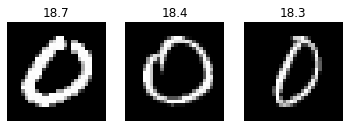

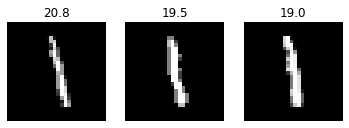

label: [ 2 ] || No data correctly predicted


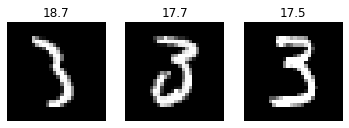

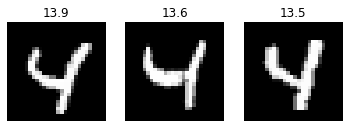

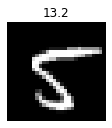

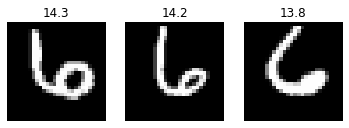

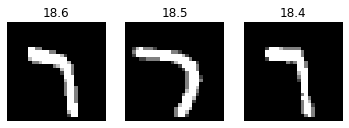

label: [ 8 ] || No data correctly predicted


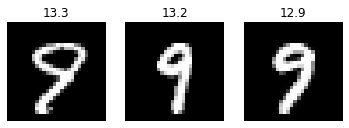

In [140]:
vis_top3_img_to_tensorboard(result, 0)
vis_top3_img_to_tensorboard(result, 1)
vis_top3_img_to_tensorboard(result, 2)
vis_top3_img_to_tensorboard(result, 3)
vis_top3_img_to_tensorboard(result, 4)
vis_top3_img_to_tensorboard(result, 5)
vis_top3_img_to_tensorboard(result, 6)
vis_top3_img_to_tensorboard(result, 7)
vis_top3_img_to_tensorboard(result, 8)
vis_top3_img_to_tensorboard(result, 9)

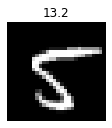

In [147]:
vis_top3_img_to_tensorboard(result, 5)

# CAM (Class Activation Map)
reference: https://github.com/jacobgil/keras-cam

In [155]:
import cv2

def vis_CAM(model, img):
    model = model
    img = np.float32(img)
    original_img = img
    print(img.shape)
    class_weights = model.model[-1].get_weights().reshape(10, 10)
    conv_outputs = model.last_activation_map(img)
    cam = np.zeros(dtype = np.float32, shape = (3, 3))
    
    for i, w in enumerate(list(class_weights[0])):
        cam += w * conv_outputs[i, :, :]    
        
    cam /= np.max(cam)
    
    cam_resize = cv2.resize(cam, (28, 28))
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap_resize = cv2.applyColorMap(np.uint8(255*cam_resize), cv2.COLORMAP_JET)
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap_resize = cv2.cvtColor(heatmap_resize, cv2.COLOR_BGR2RGB)
    
    img = heatmap_resize*0.5 + original_img

    fig = plt.figure()
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(original_img[0], cmap="gray")
    ax1.set_title('original')
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(heatmap)
    ax2.set_title('cam')
    ax2.axis("off")

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(img[0])
    ax3.set_title('resize and overlap')
    ax3.axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 1)
input.shape (10, 3, 3)


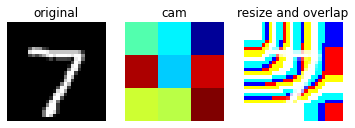

In [156]:
vis_CAM(Conv_3_layer_Model, X_test[0:1])

## for Report

<AxesSubplot:>

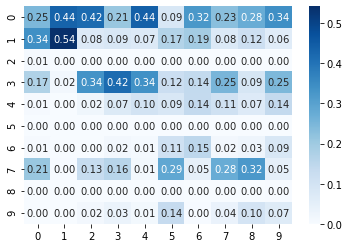

In [157]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

prob_list = predict_result
pred_list =[]
for i in range(len(X_test)):
    pred_list.append(list(prob_list[i]).index(max(prob_list[i])))

result = confusion_matrix(pred_list, Y_test, normalize="pred")
sn.heatmap(result, annot=True, fmt='.2f', cmap="Blues")